In [2]:
import sys
import copy
import numpy as np
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import time

from scipy.optimize import shgo
from quimb import *
from sympy import *
from sympy import solvers
from sympy.plotting import plot

In [3]:
# Defining the Pauli matrices to be used in our calculation
S0 = scipy.sparse.csr_matrix([[1.0, 0.0], [0.0, 1.0]])
Sx = scipy.sparse.csr_matrix([[0.0, 1.0], [1.0, 0.0]])
Sy = scipy.sparse.csr_matrix([[0.0, -1.0j], [1.0j, 0.0]])
Sz = scipy.sparse.csr_matrix([[1.0, 0.0], [0.0, -1.0]])

In [4]:
simTime, gradient = symbols('simTime gradient')

def tanhRamp(t, g, tmax):
    """
    Computes the value of the ramp at a time t for a fixed gradient g and domain [0;tmax]

    :param t: specific value of t at which we calculate the value of the function
    :param g: gradient of the ramp
    :param tmax: specifies the implied domain as in the docstring
    :return:
    """
    return 0.5 * (tanh((t - tmax / 2) / g) + 1)

def makeHamiltonianJ(N, J):
    """
    The function makeHamiltonianJ takes argument N, the length of our chain and constructs the varying 
    Hamiltonian for a chain of that length. This particular function accomodates for non-uniform J coupling. 
    The variation in time is governed by tanhRamp. The couplings varied are J_1 (decreasing from 1) and J_N-1
    (increasing from 0)
    
    :param N: integer length of the chain
    :param J: list of couplings of length N-1
    :return: 2**N x 2**N sparse matrix Hamiltonian of a chain of the specified length
    """
    H = scipy.sparse.csr_matrix((2**N, 2**N))
    
    # We must loop over all nearest neighbour interactions to develop the Hamiltonian
    for interaction in range(N-1):
        # Initialising the products which will be used to calculate the Hamiltonian matrix elements
        ProdX = 1
        ProdY = 1
        ProdZ = 1
        Jtemp = J[interaction]
        # The computation of the matrix elements is as follows:
        # (Almost) every interaction gains a contribution from a pair of spins, contributing an Sx, Sy and Sz term to H
        # There are N-1 interactions and for each one, we add a term which is a Kronecker product of Pauli matrices
        # if a spin participates in this interaction. Otherwise we take the Kronecker product with the identity to
        # ensure correct dimensionality of the matrix
        # It's clear we are looking at nearest neighbours below
        for site in range(N):
            if site == interaction or site == interaction + 1:
                ProdX = scipy.sparse.kron(ProdX, Sx, format='csr')
                ProdY = scipy.sparse.kron(ProdY, Sy, format='csr')
                ProdZ = scipy.sparse.kron(ProdZ, Sz, format='csr')
            else:
                ProdX = scipy.sparse.kron(ProdX, S0, format='csr')
                ProdY = scipy.sparse.kron(ProdY, S0, format='csr')
                ProdZ = scipy.sparse.kron(ProdZ, S0, format='csr')

        H += Jtemp * (ProdX + ProdY + ProdZ)
            
    return H

def makeHamiltonianPerturbed(N, J, h):
    """
    The function makeHamiltonianPerturbed takes argument N, the length of our chain and constructs the varying 
    Hamiltonian for a chain of that length. This particular function accomodates for non-uniform J coupling. 
    The variation in time is governed by tanhRamp. The couplings varied are J_1 (decreasing from 1) and J_N-1
    (increasing from 0). This version of the function computes the Hamiltonian under a small perturbation h of
    the magnetic field in the z direction. This is used to compute the ground state of the antiferromagnet.
    
    :param h: float magnitude of the perturbation
    :param N: integer length of the chain
    :param J: list of couplings of length N-1
    :return: 2**N x 2**N sparse matrix Hamiltonian of a chain of the specified length
    """
    H = scipy.sparse.csr_matrix((2**N, 2**N))
    
    # We must loop over all nearest neighbour interactions to develop the Hamiltonian
    for interaction in range(N-1):
        # Initialising the products which will be used to calculate the Hamiltonian matrix elements
        ProdX = 1
        ProdY = 1
        ProdZ = 1
        Jtemp = J[interaction] 
        hProd = 1
        # The computation of the matrix elements is as follows:
        # (Almost) every interaction gains a contribution from a pair of spins, contributing an Sx, Sy and Sz term to H
        # There are N-1 interactions and for each one, we add a term which is a Kronecker product of Pauli matrices
        # if a spin participates in this interaction. Otherwise we take the Kronecker product with the identity to
        # ensure correct dimensionality of the matrix
        # It's clear we are looking at nearest neighbours below
        
        # There is also a term which is responsible for the perturbation h at each site
        for site in range(N):
            if site == interaction: 
                ProdX = scipy.sparse.kron(ProdX, Sx, format='csr')
                ProdY = scipy.sparse.kron(ProdY, Sy, format='csr')
                ProdZ = scipy.sparse.kron(ProdZ, Sz, format='csr')
                hProd = scipy.sparse.kron(hProd, Sz, format='csr')
            elif site == interaction + 1:
                ProdX = scipy.sparse.kron(ProdX, Sx, format='csr')
                ProdY = scipy.sparse.kron(ProdY, Sy, format='csr')
                ProdZ = scipy.sparse.kron(ProdZ, Sz, format='csr')
                hProd = scipy.sparse.kron(hProd, S0, format='csr')

            else:
                ProdX = scipy.sparse.kron(ProdX, S0, format='csr')
                ProdY = scipy.sparse.kron(ProdY, S0, format='csr')
                ProdZ = scipy.sparse.kron(ProdZ, S0, format='csr')
                hProd = scipy.sparse.kron(hProd, S0, format='csr')


        H += Jtemp * (ProdX + ProdY + ProdZ) - h * hProd
            
    return H


In [5]:
def countBits(x):
    """
    The function counts the number of 1's in the binary representation of a base 10 integer.

    :param x: Base 10 integer
    :return: The number of ones of the integer in binary representation
    """
    # from https://stackoverflow.com/questions/10874012/how-does-this-bit-manipulation-work-in-java/10874449#10874449
    # Used because of the O(log(n)) complexity

    x = x - ((x >> 1) & 0x55555555)
    x = (x & 0x33333333) + ((x >> 2) & 0x33333333)
    x = (x + (x >> 4)) & 0x0F0F0F0F
    x = x + (x >> 8)
    x = x + (x >> 16)
    return x & 0x0000003F


def intToBinary(x, N):
    """
    The function converts a base 10 integer into a binary number of a specified length (padding with 0s if needed)

    :param x: Base 10 integer to be converted to binary
    :param N: Length of binary string required
    :return: Binary number of specified length
    """
    return ('{0:0' + str(N) + 'b}').format(x)

def makeState(configuration):
    """
    The function makeState takes argument configuration which specifies the state we want to initialise.

    :param configuration: np.array of length N with 1 meaning up and 0 meaning down, e.g. [1,0,0,1] means up-down-down-up
    :return: sparse matrix of length 2**N, the state vector in full state space
    """
    # Initialising the state vector, which will be represented in the full state space of the chain
    state = 1

    # Defining the states from which our specific state will be constructed from
    up = scipy.sparse.csr_matrix([0, 1])
    down = scipy.sparse.csr_matrix([1, 0])

    # The loop below constructs a vector of size 2^N through the Kronecker product
    i = 0
    while i < len(configuration):
        if configuration[i] == 0:
            state = scipy.sparse.kron(state, down, format="csr")
            i += 1
        elif configuration[i] == 1:
            state = scipy.sparse.kron(state, up, format="csr")
            i += 1
        else:
            return "The configuration has not been specified correctly, please read the docstring"

    return state

def makeStateArray(configuration):
    """
    The function makeStateArray takes argument configuration which specifies the state we want to initialise.

    :param configuration: np.array of length N with 1 meaning up and 0 meaning down, e.g. [1,0,0,1] means up-down-down-up
    :return: np.array of length 2**N, the state vector in full state space
    """
    # Initialising the state vector, which will be represented in the full state space of the chain
    state = 1

    # Defining the states from which our specific state will be constructed from
    up = [0, 1]
    down = [1, 0]

    # The loop below constructs a vector of size 2^N through the Kronecker product
    i = 0
    while i < len(configuration):
        if configuration[i] == 0:
            state = scipy.kron(state, down)
            i += 1
        elif configuration[i] == 1:
            state = scipy.kron(state, up)
            i += 1
        else:
            return "The configuration has not been specified correctly, please read the docstring"

    return state

def densityOperator(state):
    """
    The function take a state, in the form of an array, and creates a sparse matrix representing the density operator 
    of that state
    
    :param state: array representing a state
    :return: Sparse matrix representing the density operator of a state
    """
    
    densOp = scipy.sparse.csr_matrix((0,state.shape[1]), dtype=complex)
    for i in range(state.shape[1]):
        densOp = scipy.sparse.vstack([densOp, state[:,i].A*state])
    
    return densOp.tocsr()

def makeSubSpace(N, Sz):
    """
    The function creates a matrix of vectors in a particular region of the state space of the spin chain, with a 
    particular value of Sz, i.e. a certain number of 1's and 0's in their binary representation. This will be used
    to contract the full Hamiltonian in order to make computations easier, as the Hamiltonian preserves Sz.

    :param N: Length of spin chain
    :param Sz: Total number of 1's in states
    :return: Sparse matrix defining the Sz subspace of the Hamiltonian
    """
    ss = scipy.sparse.csr_matrix((0,2**N),dtype=int)
    for i in range(2**N-1):
        if countBits(i) == Sz:
            ss = scipy.sparse.vstack([ss,makeState([int(j) for j in intToBinary(i, N)])])
    
    return ss.tocsr()

def makeAFMSubSpace(N, Sz):
    """
    The function creates a matrix of vectors in a particular region of the state space of the spin chain, with a 
    particular value of Sz, i.e. a certain number of 1's and 0's in their binary representation and ending with a 1. 
    This will be used to contract the Hamiltonian to the subspace in which we can compute the AFM state fidelity
    
    :param N: Length of spin chain
    :param Sz: Total number of 1's in states
    :return: Sparse matrix defining the Sz subspace of the Hamiltonian, with vectors ending in 1s only 
    """
    ss = scipy.sparse.csr_matrix((0,2**N),dtype=int)
    for i in range(2**N-1):
        if countBits(i) == Sz:
            if intToBinary(i, N)[-1] == '1':
                ss = scipy.sparse.vstack([ss,makeState([int(j) for j in intToBinary(i, N)])])
    
    return ss.tocsr()

In [6]:
def partialTrace(densOp, N, optimize=False):
    """
    Computes the reduced density matrix for a density operator by tracing out all qubits except the last.
    Inspired by https://scicomp.stackexchange.com/questions/30052/calculate-partial-trace-of-an-outer-product-in-python
    
    :param densOp: Matrix representing the density operator of an array of qubits
    :param N: Chain length
    :oaram optimize: np.einsum option, False by default
    :return: Matrix representing the density operator of an array of qubits keeping only the last qubit state
    """
    keep = np.asarray(N-1)
    dims = [2 for i in range(N)]
    Ndim = len(dims)
    Nkeep = np.prod(dims[keep])

    idx1 = [i for i in range(Ndim)]
    idx2 = [Ndim+i if i in keep else i for i in range(Ndim)]
    rho_a = densOp.reshape(np.tile(dims,2))
    rho_a = np.einsum(rho_a, idx1+idx2, optimize=optimize)
    return rho_a.reshape(Nkeep, Nkeep)

In [7]:
state = (1/np.sqrt(2))*makeState([1,1,1,1,1,0,1,1,1])+(1/np.sqrt(2))*makeState([0,0,0,1,1,1,0,0,0])
do = densityOperator(state).toarray()

partialTrace(do, 9)

array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])

In [305]:
def saveMatrices(N, Sz):
    H_N = makeHamiltonianJ(N,[1 for i in range (N-1)])
    V = makeSubSpace(N,Sz)
    F = makeAFMSubSpace(N,Sz)

    H_basis = V*H_N*V.transpose()

    scipy.sparse.save_npz('V_'+str(N)+'_allJ_Sz_'+str(2*Sz-N)+'subspace.npz', V.transpose())
    #This saves V^\dagger to be able to transform basis vectors 
    
    scipy.sparse.save_npz('H_'+str(N)+'_allJ_Sz_'+str(2*Sz-N)+'subspace.npz', H_basis)
    #This saves H in the new basis
    
    scipy.sparse.save_npz('F_'+str(N)+'_allJ_Sz_'+str(2*Sz-N)+'subspace.npz', F.transpose())
    #This saves F^\dagger to be able to transform basis vectors 
    

In [475]:
saveMatrices(15,1)


The limiting step for the above process is makeSubSpace(N,N/2), hence possibly the makeState(configuration) function. The computation runs for a short enough amount of time (i.e. under a minute) for N=14. 

In [16]:
def rungeKuttaRamp(t, dt, grad, tmax):
    """
    The function gives a tuplet of parameters to feed into the rungeKuttaStep function for the evolution of the
    Hamiltonian at 3  different timesteps for a given gradient parameter and tmax.

    :param t: time at which the tuple is generated
    :param dt: timestep
    :param grad: gradient parameter in the ramp
    :param tmax: max time of the ramp
    :return: parameters for H at t, t+dt/2 and t+dt
    """

    return [float(tanhRamp(simTime, grad, tmax).subs(simTime, t)),
            float(tanhRamp(simTime, grad, tmax).subs(simTime, t + dt / 2)),
            float(tanhRamp(simTime, grad, tmax).subs(simTime, t + dt))]

def rungeKuttaStep(state, Hamiltonian, Hamiltonian_later, Hamiltonian_latest, dt):
    """
    The function evolves the input state by the input Hamiltonian for a timestep dt using the Runge-Kutta
    approximation

    :param state: input state as vector
    :param Hamiltonian: input Hamiltonian
    :param Hamiltonian_later: Hamiltinian evolved by dt/2 
    :param Hamiltonian_later: Hamiltinian evolved by dt
    :param dt: timestep
    :return: evolved state after a timestep dt
    """
    
    k1 = -1j*dt*Hamiltonian*state
    k2 = -1j*dt*Hamiltonian_later*(state+k1/2)
    k3 = -1j*dt*Hamiltonian_later*(state+k2/2)
    k4 = -1j*dt*Hamiltonian_latest*(state+k3)
    
    return state + (1/6)*(k1+2*k2+2*k3+k4)

In [10]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm


def normalizeSparse(v):
    norm = scipy.sparse.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm


def makeStateAFM(N, kopt=6):
    """
    The function computes the antiferromagnetic ground state by taking the lowest energy eigenvector for the 
    Heisenberg Hamiltonian in the full state space for a chain of length N

    :param N: length of the chain
    :return: full state space representation of the antiferromagnetic ground state
    """
    H = makeHamiltonianJ(N,[1 for i in range(N-1)])
    eigval, eigvec = scipy.sparse.linalg.eigsh(H, k=kopt, which='SA')
    return eigvec[:,0]

def phaseCorrectAFM(N, vec):
    """
    The function computes the global phase of a given antiferromagnetic ground state and reduces it to 0 
    for a chain of length N

    :param N: length of the chain
    :param vec: full state space representation of antiferromagnetic ground state
    :return: Dephased representation of the antiferromagnetic ground state in the full space
    """
    V = scipy.sparse.load_npz('V_'+str(N)+'_allJ_Sz_0subspace.npz')
    contVec = V.transpose()*vec
    phi = Symbol('phi')
    sol = solve(im(exp(-1j*phi)*contVec[0]) , phi)[0]
    phase = complex((exp(-1j*sol[re(phi)])).evalf())
    
    return V*np.real(phase*contVec)

Below is a Runge-Kutta simulation of the dynamics of using the full Hamiltonian.

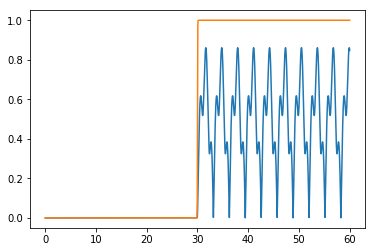

In [92]:
initialState = makeStateArray([1,0,0,0])
H = makeHamiltonianJ(4,[1,1,0])
Htar = makeHamiltonianJ(4,[0,1,1])

T = 60
dt = 0.005
grad = 4/100

t_curr = 0
currentState = initialState
targetState = makeStateArray([0,0,0,1])
f = []
norm = []
ramps = []


while t_curr < T:
    #computing the proportions of the Hamiltonian at each timestep, along with the values needed to compute RK step
    ramp = rungeKuttaRamp(t_curr,dt,grad,T)
    
    #updating the Hamiltonian
    Hcurr = (1-ramp[0])*H + ramp[0]*Htar
    H_dt2 = (1-ramp[1])*H + ramp[1]*Htar
    H_dt = (1-ramp[2])*H + ramp[2]*Htar
    
    #performing the Runge-Kutta step
    currentState = rungeKuttaStep(currentState, Hcurr, H_dt2, H_dt, dt)
    #renormalising the state
    currentState = normalize(currentState)
    
    #computing the fidelity
    f.append(np.abs(np.dot(targetState, currentState)))
    ramps.append(ramp[0])

    t_curr += dt
    
plt.plot([i*dt for i in range(len(f))],np.square(f))
plt.plot([i*dt for i in range(len(ramps))],ramps)

plt.show()

And the computation using contracted spaces: (best for ferromagnetic simulation as of 19.04)

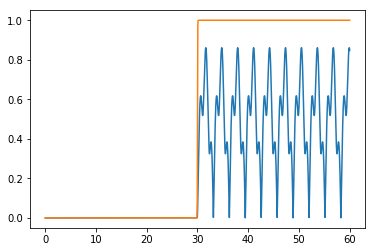

In [137]:
initialState_fs = makeState([1,0,0,0]).transpose()
targetState_fs = makeState([0,0,0,1]).transpose()
H_fs = makeHamiltonianJ(4,[1,1,0])
Htar_fs = makeHamiltonianJ(4,[0,1,1])

V = scipy.sparse.load_npz('V_4_allJ_Sz_-1subspace.npz')

initialState = V.transpose()*initialState_fs
targetState = V.transpose()*targetState_fs
H = V.transpose()*H_fs*V
Htar = V.transpose()*Htar_fs*V

dt = 0.01
grad = 5
p=0.01
T = -2*grad*atanh(2*p-1)

t_curr = 0
currentState = initialState
f = []
norm = []
ramps = []


while t_curr < T:
    #computing the proportions of the Hamiltonian at each timestep, along with the values needed to compute RK step
    ramp = rungeKuttaRampNew(t_curr,dt,grad,p)
    
    #updating the Hamiltonian
    Hcurr = (1-ramp[0])*H + ramp[0]*Htar
    H_dt2 = (1-ramp[1])*H + ramp[1]*Htar
    H_dt = (1-ramp[2])*H + ramp[2]*Htar
    
    #performing the Runge-Kutta step
    currentState = rungeKuttaStep(currentState, Hcurr, H_dt2, H_dt, dt)
    #renormalising the state
    currentState = normalizeSparse(currentState)
    
    #computing the fidelity
    f.append(np.abs(np.dot(flatten(targetState.toarray()), flatten(currentState.toarray()))))
    ramps.append(ramp[0])

    t_curr += dt
    
plt.plot([i*dt for i in range(len(f))],np.square(f))
plt.plot([i*dt for i in range(len(ramps))],ramps)

plt.show()

And using density matrix to compute fidelity: (only understood way of computing fidelity for antiferromagnet as of 19.04)

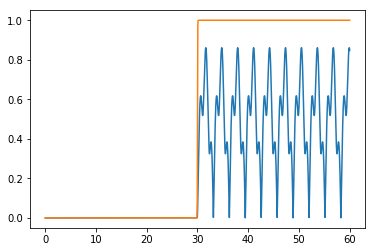

In [139]:
initialState = makeStateArray([1,0,0,0])
inOp = [[0,0],[0,1]]
H = makeHamiltonianJ(4,[1,1,0])
Htar = makeHamiltonianJ(4,[0,1,1])

T = 60
dt = 0.005
grad = 4/100

t_curr = 0
currentState = initialState
f = []
norm = []
ramps = []


while t_curr < T:
    #computing the proportions of the Hamiltonian at each timestep, along with the values needed to compute RK step
    ramp = rungeKuttaRamp(t_curr,dt,grad,T)
    
    #updating the Hamiltonian
    Hcurr = (1-ramp[0])*H + ramp[0]*Htar
    H_dt2 = (1-ramp[1])*H + ramp[1]*Htar
    H_dt = (1-ramp[2])*H + ramp[2]*Htar
    
    #performing the Runge-Kutta step
    currentState = rungeKuttaStep(currentState, Hcurr, H_dt2, H_dt, dt)
    #renormalising the state
    currentState = normalize(currentState)
    
    densOp = qu(currentState, qtype='dop')
    densOp = ptr(densOp, [2]*4,keep=3)
    #finding the partial trace of the matrix and extracting fidelity
    f.append(np.trace(densOp*inOp))
    ramps.append(ramp[0])

    t_curr += dt
    
plt.plot([i*dt for i in range(len(f))],f)
plt.plot([i*dt for i in range(len(ramps))],ramps)

plt.show()

With the antiferromagnetic ground state as the initial state: (note the computation for fidelity is conceptually wrong; used as proxy here due to previous work)

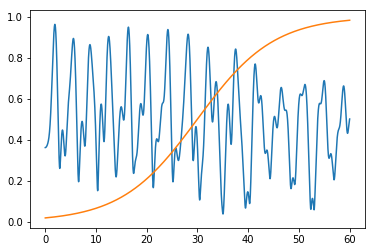

In [40]:
# Initial state and target state in the full space
AFMState = makeStateAFM(8)
AFMState = phaseCorrectAFM(8, AFMState)
initialState_fs = scipy.kron([0,1], AFMState)
targetState_fs = scipy.kron(AFMState, [0,1])

# Loading the sparse matrix V\dagger 
V = scipy.sparse.load_npz('V_9_allJ_Sz_1subspace.npz')
# Transforming initial and target state into contracted space

initialState = normalize(V.transpose()*initialState_fs)
targetState = normalize(V.transpose()*targetState_fs)

# Setting problem parameters
T = 60

# Initialising the initial and target Hamiltonian and transforming into contracted space
H_fs = makeHamiltonianJ(9,[1,1,1,1,1,1,1,1,0])
Htar_fs = makeHamiltonianJ(9,[0,1,1,1,1,1,1,1,1])
H = V.transpose()*H_fs*V
Htar = V.transpose()*Htar_fs*V

# Initialising the problem
dt = 0.01
f = []
ramps = []
t_curr = 0
grad = 15
currentState = initialState

while t_curr < T:
    #computing the proportions of the Hamiltonian at each timestep, along with the values needed to compute RK step
    ramp = rungeKuttaRamp(t_curr,dt,grad,T)
    
    #updating the Hamiltonian
    Hcurr = (1-ramp[0])*H + ramp[0]*Htar
    H_dt2 = (1-ramp[1])*H + ramp[1]*Htar
    H_dt = (1-ramp[2])*H + ramp[2]*Htar
    
    #performing the Runge-Kutta step
    currentState = rungeKuttaStep(currentState, Hcurr, H_dt2, H_dt, dt)
    #renormalising the state
    currentState = normalize(currentState)
    
    #computing the fidelity
    f.append(np.abs(np.dot(targetState, currentState)))
    ramps.append(ramp[0])
    t_curr += dt
    
plt.plot([i*dt for i in range(len(f))],f)
plt.plot([i*dt for i in range(len(f))],ramps)
plt.show()

With the antiferromagnetic ground state as the starting state and using density matrices to compute fidelity:

In [ ]:
# Initial state and target state in the full space
N = 8

AFMState = makeStateAFM(N)
AFMState = phaseCorrectAFM(N, AFMState)

initialState_fs = scipy.sparse.kron([0,1], AFMState).transpose()
inOp = [[0,0],[0,1]]

# Loading the sparse matrix V\dagger 
V = scipy.sparse.load_npz('V_'+str(N+1)+'_allJ_Sz_1subspace.npz')
# Transforming initial and target state into contracted space

initialState = V.transpose()*initialState_fs

# Setting problem parameters
couplings_fs = [1 for i in range(N)]
couplingstar_fs = [1 for i in range(N)]
couplings_fs.append(0)
couplingstar_fs.insert(0,0)

# Initialising the initial and target Hamiltonian and transforming into contracted space
H_fs = makeHamiltonianJ(N+1,couplings_fs)
Htar_fs = makeHamiltonianJ(N+1,couplingstar_fs)
H = V.transpose()*H_fs*V
Htar = V.transpose()*Htar_fs*V

# Initialising the problem
T = 60
dt = 0.01
f = []
ramps = []
t_curr = 0
grad = 2
currentState = initialState
while t_curr < T:
    #computing the proportions of the Hamiltonian at each timestep, along with the values needed to compute RK step
    ramp = rungeKuttaRamp(t_curr,dt,grad,T)
    
    #updating the Hamiltonian
    Hcurr = (1-ramp[0])*H + ramp[0]*Htar
    H_dt2 = (1-ramp[1])*H + ramp[1]*Htar
    H_dt = (1-ramp[2])*H + ramp[2]*Htar
    
    #performing the Runge-Kutta step
    currentState = rungeKuttaStep(currentState, Hcurr, H_dt2, H_dt, dt)
    #renormalising the state
    currentState = normalizeSparse(currentState)
    currentState_fs = V*currentState
    
    #computing the density matrix for the current state
    densOp = qu(currentState_fs, qtype='dop')
    densOp = ptr(densOp, [2]*(N+1),keep=N)
    #finding the partial trace of the matrix and extracting fidelity
    f.append(np.trace(densOp*inOp))
    ramps.append(ramp[0])


    t_curr += dt
    
plt.plot([i*dt for i in range(len(f))],f)
plt.plot([i*dt for i in range(len(ramps))],ramps)

plt.show()

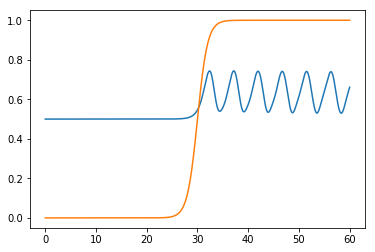

In [171]:
# Initial state and target state in the full space
N = 12

AFMState = makeStateAFM(N)
AFMState = phaseCorrectAFM(N, AFMState)

initialState_fs = scipy.sparse.kron([0,1], AFMState).transpose()

# Loading the sparse matrix V\dagger 
V = scipy.sparse.load_npz('V_'+str(N+1)+'_allJ_Sz_1subspace.npz')
F = scipy.sparse.load_npz('F_'+str(N+1)+'_allJ_Sz_1subspace.npz')
# Transforming initial and target state into contracted space

initialState = V.transpose()*initialState_fs

# Setting problem parameters
couplings_fs = [1 for i in range(N)]
couplingstar_fs = [1 for i in range(N)]
couplingstar_fs.append(0)
couplings_fs.insert(0,0)

# Initialising the initial and target Hamiltonian and transforming into contracted space
H_fs = makeHamiltonianJ(N+1,couplings_fs)
Htar_fs = makeHamiltonianJ(N+1,couplingstar_fs)
H = V.transpose()*H_fs*V
Htar = V.transpose()*Htar_fs*V

# Initialising the problem
T = 60
dt = 0.01
f = []
ramps = []
t_curr = 0
grad = 2
currentState = initialState
while t_curr < T:
    #computing the proportions of the Hamiltonian at each timestep, along with the values needed to compute RK step
    ramp = rungeKuttaRamp(t_curr,dt,grad,T)
    
    #updating the Hamiltonian
    Hcurr = (1-ramp[0])*H + ramp[0]*Htar
    H_dt2 = (1-ramp[1])*H + ramp[1]*Htar
    H_dt = (1-ramp[2])*H + ramp[2]*Htar
    
    #performing the Runge-Kutta step
    currentState = rungeKuttaStep(currentState, Hcurr, H_dt2, H_dt, dt)
    #renormalising the state
    currentState = normalizeSparse(currentState)
    currentState_f = F.transpose()*V*currentState
    

    f.append(abs(currentState_f).power(2).sum())
    ramps.append(ramp[0])


    t_curr += dt
    
plt.plot([i*dt for i in range(len(f))],f)
plt.plot([i*dt for i in range(len(ramps))],ramps)

plt.show()

Here I define new ramps, ones which will run for a varying tmax, in order to have the transition between H and H_tar to start and end at the same proportions for each choice of gradient. I will later optimize over this.

In [143]:
simTime, gradient = symbols('simTime gradient')
def tanhRampNew(t, g, p):
    """
    Computes the value of the ramp at a time t for a fixed gradient g and, starting value p and final value 1-p

    :param t: specific value of t at which we calculate the value of the function
    :param g: gradient of the ramp
    :param p: specifies the initial and final value of tanhRampNew, also specifying its range
    :return:
    """
    return 0.5 * (tanh((t + (g * atanh((2 * p) - 1))) / g) + 1)


def rungeKuttaRampNew(t, dt, grad, p):
    """
    The function gives a tuplet of parameters to feed into the rungeKuttaStep function for the evolution of the
    Hamiltonian at 3  different timesteps for a given gradient parameter.

    :param t: time at which the tuple is generated
    :param dt: timestep
    :param grad: gradient parameter in the ramp
    :return: parameters for H at t, t+dt/2 and t+dt
    """

    return [float(tanhRampNew(simTime, grad, p).subs(simTime, t)),
            float(tanhRampNew(simTime, grad, p).subs(simTime, t + dt / 2)),
            float(tanhRampNew(simTime, grad, p).subs(simTime, t + dt))]

In [144]:
rungeKuttaRampNew(1, 0.01, 4, 0.01)

[0.0163809460257901, 0.016421276292581166, 0.016461704191648274]

And finally running the simulation for the new, T variable ramp

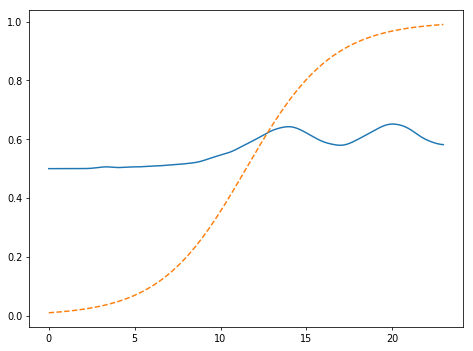

In [409]:
# Initial state and target state in the full space
N = 16

AFMState = makeStateAFM(N, kopt=1)
AFMState = phaseCorrectAFM(N, AFMState)

initialState_fs = scipy.sparse.kron([0,1], AFMState).transpose()
initialState_fs = normalizeSparse(initialState_fs)

# Loading the sparse matrix V\dagger 
V = scipy.sparse.load_npz('V_'+str(N+1)+'_allJ_Sz_1subspace.npz')
F = scipy.sparse.load_npz('F_'+str(N+1)+'_allJ_Sz_1subspace.npz')

# Transforming initial state into contracted space
initialState = V.transpose()*initialState_fs

# Setting problem parameters
couplings_fs = [1 for i in range(N)]
couplingstar_fs = [1 for i in range(N)]
couplingstar_fs.append(0)
couplings_fs.insert(0,0)


# Initialising the initial and target Hamiltonian and transforming into contracted space
H_fs = makeHamiltonianJ(N+1,couplings_fs)
Htar_fs = makeHamiltonianJ(N+1,couplingstar_fs)
H = V.transpose()*H_fs*V
Htar = V.transpose()*Htar_fs*V
currentState = initialState

# Initialising the problem
dt = 0.01
f = []
ramps = []
t_curr = 0
# the gradient parameter of the ramp
grad = 5
# p signifies the value of the ramp at t=0
p = 0.01
# total simulation runtime depends on grad and p
T = -2*grad*atanh(2*p-1)


while t_curr < T:
    #computing the proportions of the Hamiltonian at each timestep, along with the values needed to compute RK step
    ramp = rungeKuttaRampNew(t_curr,dt,grad,p)
    
    #updating the Hamiltonian
    Hcurr = (1-ramp[0])*H + ramp[0]*Htar
    H_dt2 = (1-ramp[1])*H + ramp[1]*Htar
    H_dt = (1-ramp[2])*H + ramp[2]*Htar
    
    #performing the Runge-Kutta step
    currentState = rungeKuttaStep(currentState, Hcurr, H_dt2, H_dt, dt)
    #renormalising the state
    currentState = normalizeSparse(currentState)
    currentState_f = F.transpose()*V*currentState
    

    f.append(abs(currentState_f).power(2).sum())
    ramps.append(ramp[0])


    t_curr += dt

plt.figure(figsize=(8,6), dpi=70)
plt.plot([i*dt for i in range(len(f))],f)
plt.plot([i*dt for i in range(len(ramps))],ramps, '--')

plt.show()

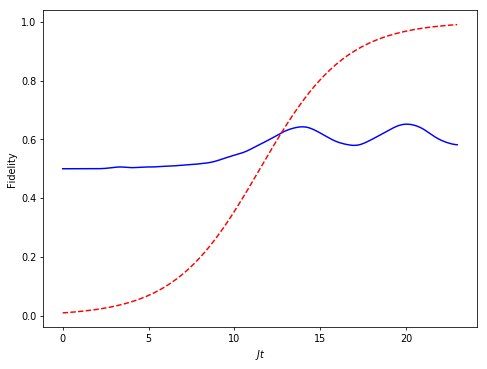

In [410]:
plt.figure(figsize=(8,6), dpi=70)
plt.plot([i*dt for i in range(len(f))],f, color='blue')
plt.plot([i*dt for i in range(len(ramps))],ramps, '--', color='red')
plt.ylabel("Fidelity")
plt.xlabel("$Jt$")

plt.show()

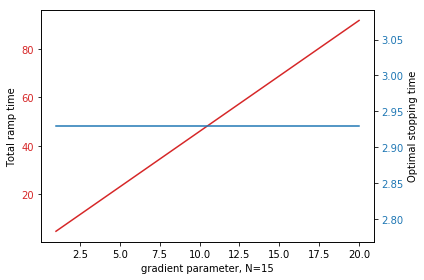

In [108]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('gradient parameter, N=15')
ax1.set_ylabel('Total ramp time')
ax1.plot(grads, Ts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Optimal stopping time')  # we already handled the x-label with ax1
ax2.plot(grads, maxFidx, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [464]:
params = initialiseSimulation(3, 'FM', 'backward', k=1)
fidelitiesbackN2FM = []
dg = 0.3

for i in range(3,303):
    print(i*dg)
    fidelitiesbackN2FM.append(maxFidelityCostFunction(i*dg, 'FM', simulationparameters=params, dt=0.01, p=0.01))
print(fidelitiesbackN2FM)


0.8999999999999999
1.2
1.5
1.7999999999999998
2.1
2.4
2.6999999999999997
3.0
3.3
3.5999999999999996
3.9
4.2
4.5
4.8
5.1
5.3999999999999995
5.7
6.0
6.3
6.6
6.8999999999999995
7.199999999999999
7.5
7.8
8.1
8.4
8.7
9.0
9.299999999999999
9.6
9.9
10.2
10.5
10.799999999999999
11.1
11.4
11.7
12.0
12.299999999999999
12.6
12.9
13.2
13.5
13.799999999999999
14.1
14.399999999999999
14.7
15.0
15.299999999999999
15.6
15.899999999999999
16.2
16.5
16.8
17.099999999999998
17.4
17.7
18.0
18.3
18.599999999999998
18.9
19.2
19.5
19.8
20.099999999999998
20.4
20.7
21.0
21.3
21.599999999999998
21.9
22.2
22.5
22.8
23.099999999999998
23.4
23.7
24.0
24.3
24.599999999999998
24.9
25.2
25.5
25.8
26.099999999999998
26.4
26.7
27.0
27.3
27.599999999999998
27.9
28.2
28.5
28.799999999999997
29.099999999999998
29.4
29.7
30.0
30.299999999999997
30.599999999999998
30.9
31.2
31.5
31.799999999999997
32.1
32.4
32.699999999999996
33.0
33.3
33.6
33.9
34.199999999999996
34.5
34.8
35.1
35.4
35.699999999999996
36.0
36.3
36.6
36.9


KeyboardInterrupt: 

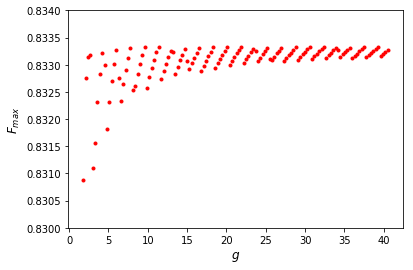

In [448]:
plt.scatter([i*dg for i in range(3,len(fidelitiesbackN2)+3)][3:],np.dot(-1,fidelitiesbackN2[3:]),marker = '.', color='r')
plt.ylim(0.83, 0.834)
plt.ylabel("$F_{max}$", fontsize=12)
plt.xlabel("$g$", fontsize=12)
plt.show()

In [455]:
fidelitiesbackN2.index(max(fidelitiesbackN2))

3

In [ ]:
params = initialiseSimulation(15, 'AFM', 'backward', k=1)
fidelitiesbackN15 = []
dg = 0.3

for i in range(3,120):
    print(i*dg)
    fidelitiesbackN15.append(maxFidelityCostFunction(i*dg, 'AFM', simulationparameters=params, dt=0.01, p=0.01))
print(fidelitiesbackN15)


In [ ]:
params = initialiseSimulation(15, 'FM', 'backward', k=1)
fidelitiesbackN15FM = []
dg = 0.3

for i in range(3,120):
    print(i*dg)
    fidelitiesbackN15FM.append(maxFidelityCostFunction(i*dg, 'FM', simulationparameters=params, dt=0.01, p=0.01))
print(fidelitiesbackN15FM)


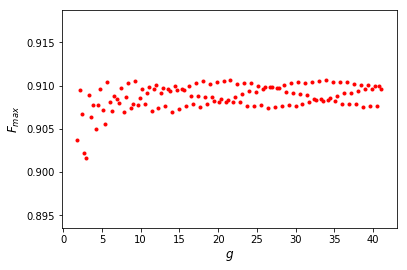

In [466]:
plt.scatter([i*dg for i in range(3,len(fidelitiesbackN2FM)+3)][3:],np.dot(-1,fidelitiesbackN2FM[3:]),marker = '.', color='r')
plt.ylabel("$F_{max}$", fontsize=12)
plt.xlabel("$g$", fontsize=12)
plt.show()

In [453]:
np.polyfit([i*dg for i in range(3,len(fidelitiesbackN2FM)+3)][3:],np.dot(-1,fidelitiesbackN2FM[3:]),1)

array([6.58316260e-06, 8.32989257e-01])

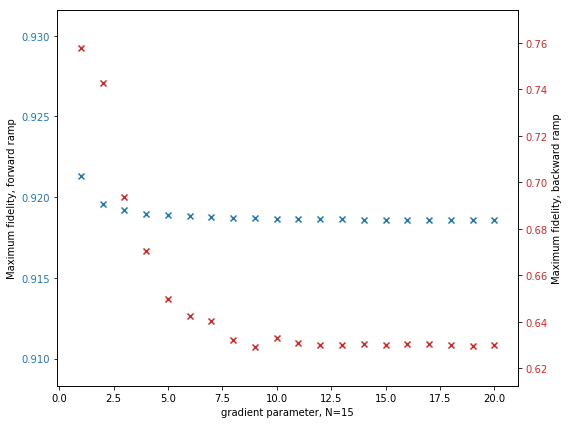

In [298]:
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'tab:blue'
ax1.scatter(grads, np.dot(-1,fidelitiesN15), color=color, marker='x')
ax1.set_xlabel('gradient parameter, N=15')
ax1.set_ylabel('Maximum fidelity, forward ramp')
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Maximum fidelity, backward ramp')  # we already handled the x-label with ax1
ax2.scatter(grads, np.dot(-1, fidelitiesbackN15), color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Now, I prepare the cost function that will be optimized. In essence, I will minimize -max(f) or -max(f)/T. First, I write a function to compute H and H_tar and save it to my hard drive to reduce the runtime during optimizaiton.

In [374]:
def saveHamiltonians(N, rampdir, magneticorder='AFM'):
    """
    The function saves the target and initial Hamiltonians for N qubits given a value N as .npz files
    
    :param N: length of original antiferromagnetic chain
    :param rampdir: string 'forward' or 'backward' -> allows to either do a ramp from (J_N-1 = 0 to J_N-1 = J 
    and J_1 = J to J_1 = 0 <=> 'forward') or (J_1 = 0 to J_1 = J and J_N-1 = J to J_N-1 = 0 <=> 'backward') 

    :return: None
    """    
    
    # Note - requires precalculated V matrix
    if magneticorder == 'AFM':
        V = scipy.sparse.load_npz('V_'+str(N)+'_allJ_Sz_1subspace.npz')
    
    elif magneticorder == 'FM':
        V = scipy.sparse.load_npz('V_'+str(N)+'_allJ_Sz_'+str(-(N-2))+'subspace.npz')
    
    if rampdir == 'forward':
        # Setting Hamiltonian couplings
        couplings_fs = [1 for i in range(N-1)]
        couplingstar_fs = [1 for i in range(N-1)]
        couplings_fs.append(0)
        couplingstar_fs.insert(0,0)
    elif rampdir == 'backward':
        couplings_fs = [1 for i in range(N-1)]
        couplingstar_fs = [1 for i in range(N-1)]
        couplingstar_fs.append(0)
        couplings_fs.insert(0,0)
    
    # Initialising the initial and target Hamiltonian and transforming into contracted space
    H_fs = makeHamiltonianJ(N,couplings_fs)
    Htar_fs = makeHamiltonianJ(N,couplingstar_fs)
    H = V.transpose()*H_fs*V
    Htar = V.transpose()*Htar_fs*V
    
    scipy.sparse.save_npz('Hinitial_'+str(N)+rampdir+magneticorder+'.npz', H)
    scipy.sparse.save_npz('Htarget_'+str(N)+rampdir+magneticorder+'.npz', Htar)
    
    print('Hamiltonians saved successfully.')
    
    return 

In [543]:
saveHamiltonians(5, 'backward', magneticorder='AFM')

Hamiltonians saved successfully.


In [550]:
def initialiseSimulation(N, magneticorder, rampdir, k=6):

    if magneticorder == 'AFM':
        AFMState = makeStateAFM(N-1, kopt=k)
        AFMState = phaseCorrectAFM(N-1, AFMState)
        targetState = 0
        initialState_fs = scipy.sparse.kron([0,1], AFMState).transpose()

        # Loading the sparse matrix V\dagger and
        V = scipy.sparse.load_npz('V_'+str(N)+'_allJ_Sz_1subspace.npz')
        F = scipy.sparse.load_npz('F_'+str(N)+'_allJ_Sz_1subspace.npz')

    elif magneticorder == 'FM':

        config = [0 for i in range(N-1)]
        config.insert(0,1)

        configtarget = [0 for i in range(N-1)]
        configtarget.insert(len(configtarget), 1)

        initialState_fs = makeState(config).transpose()
        targetState_fs = makeState(configtarget).transpose()

        V = scipy.sparse.load_npz('V_'+str(N)+'_allJ_Sz_'+str(-(N-2))+'subspace.npz')
        F = scipy.sparse.load_npz('F_'+str(N)+'_allJ_Sz_'+str(-(N-2))+'subspace.npz')
        targetState = V.transpose()*targetState_fs


    # Transforming initial state into contracted space
    initialState = V.transpose()*initialState_fs

    H = scipy.sparse.load_npz('Hinitial_'+str(N)+rampdir+magneticorder+'.npz')
    Htar = scipy.sparse.load_npz('Htarget_'+str(N)+rampdir+magneticorder+'.npz')

    return initialState, targetState, H, Htar, V, F
    
def maxFidelityCostFunction(grad, magneticorder=None, simulationparameters=None, dt=0.01, p=0.01):
    
    initialState, targetState, H, Htar, V, F = simulationparameters 
    
    # Calculating the simulation time
    T = -2*grad*atanh(2*p-1)
    
    # Setting up the simulation
    currentState = initialState
    f = []
    ramps = []
    t_curr = 0

    while t_curr < T:
        # Computing the proportions of the Hamiltonian at each timestep, along with the values needed to compute RK step

        ramp = rungeKuttaRampNew(t_curr,dt,grad,p)
 
        # Updating the Hamiltonian
        
        Hcurr = (1-ramp[0])*H + ramp[0]*Htar
        H_dt2 = (1-ramp[1])*H + ramp[1]*Htar
        H_dt = (1-ramp[2])*H + ramp[2]*Htar

        # Performing the Runge-Kutta step
        currentState = rungeKuttaStep(currentState, Hcurr, H_dt2, H_dt, dt)
        
        # Renormalising the state
        currentState = normalizeSparse(currentState)
        if magneticorder == 'AFM':
            # Transforming the state into the space to calculate fidelity
            currentState_f = F.transpose()*V*currentState
        
            # Appending current fidelity to array
            f.append(abs(currentState_f).power(2).sum())
            
        elif magneticorder == 'FM':
            f.append(np.abs(np.dot(flatten(targetState.toarray()), flatten(currentState.toarray()))))
        
        ramps.append(ramp[0])
        t_curr += dt

    #plt.figure(figsize=(8,6), dpi=70)
    #plt.plot([i*dt for i in range(len(f))],f, color='blue')
    #plt.plot([i*dt for i in range(len(ramps))],ramps, '--', color='red')
    #plt.ylabel("Fidelity")
    #plt.xlabel("$Jt$")
    #plt.show()
    
    return -np.max(f)

In [548]:
params = initialiseSimulation(17,'FM','forward')
ff1 = maxFidelityCostFunction(3, 'FM', simulationparameters=params, dt=0.01, p=0.01)
ff2 = maxFidelityCostFunction(5, 'FM', simulationparameters=params, dt=0.01, p=0.01)
ff3 = maxFidelityCostFunction(8, 'FM', simulationparameters=params, dt=0.01, p=0.01)
ff4 = maxFidelityCostFunction(12, 'FM', simulationparameters=params, dt=0.01, p=0.01)

[0.0, 0.0, 0.0, 1.9555560711533256e-33, 8.655991744788018e-31, 3.4703092684588077e-29, 5.872484331665027e-28, 6.0552142006978665e-27, 4.478742239936773e-26, 2.600347138110534e-25, 1.2534892426382812e-24, 5.2098179575293596e-24, 1.9177677591437856e-23, 6.377873698938315e-23, 1.9456445034678712e-22, 5.509785701418453e-22, 1.4622880084965878e-21, 3.6654950941279925e-21, 8.73419158592628e-21, 1.989010398891148e-20, 4.348608271997899e-20, 9.163241119873055e-20, 1.867181506150402e-19, 3.689977560660472e-19, 7.090270243070829e-19, 1.3276168453550625e-18, 2.4272269776648903e-18, 4.3404730874583294e-18, 7.603832473996599e-18, 1.3067914997830022e-17, 2.2060076565170075e-17, 3.6621017630632666e-17, 5.984472900057338e-17, 9.636121201058672e-17, 1.530144057827303e-16, 2.3980442003095107e-16, 3.7118436048714054e-16, 5.678287739434004e-16, 8.590242502570804e-16, 1.2858744367251425e-15, 1.9055633318444494e-15, 2.796984198432328e-15, 4.0681190567098786e-15, 5.865648130995563e-15, 8.387382875672512e-15,

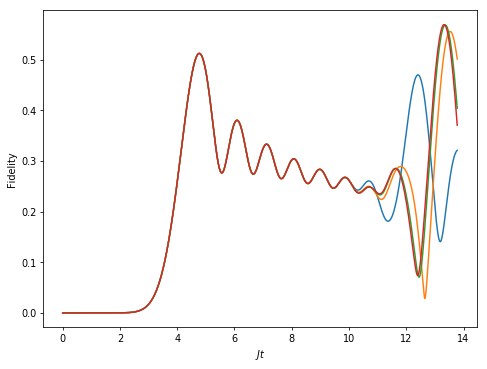

In [549]:
t_max = len(ff1)
ts = [i*dt for i in range(t_max)]
plt.figure(figsize=(8,6), dpi=70)

plt.plot(ts, ff1)
plt.plot(ts, ff2[:t_max])
plt.plot(ts, ff3[:t_max])
plt.plot(ts, ff4[:t_max])
plt.xlabel("$Jt$")
plt.ylabel("Fidelity")
plt.show()

In [511]:
params = initialiseSimulation(5, 'AFM', 'forward')
maxFidelityCostFunction(5, 'AFM', simulationparameters=params, dt=0.01, p=0.01)

(-0.9876848260086987, 116)

In [262]:
Ns = []
Ntimes = []
results = [] 

for N in range(7,19,2):
    
    params = initialiseSimulation(N, 'AFM', 'forward')
    t_init=time.time()
    result = maxFidelityCostFunction(20, simulationparameters=params, dt=0.01, p=0.01)
    elapsed=time.time()-t_init
    
    Ns.append(N)
    Ntimes.append(elapsed)
    results.append(result)

# taken from pycharm, which runs the algorithm for N=19, 21 correctly for some reason
Ns.append(19)
Ntimes.append(2382.756406068802)
results.append(-0.8982600848913083)

Ns.append(21)
Ntimes.append(5912.075711011887)
results.append(-0.8892604952536681)

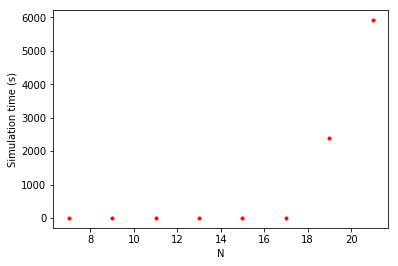

In [517]:
plt.scatter(Ns, Ntimes, color='red', marker='.')
plt.xlabel("N")
plt.ylabel("Simulation time (s)")
plt.show()

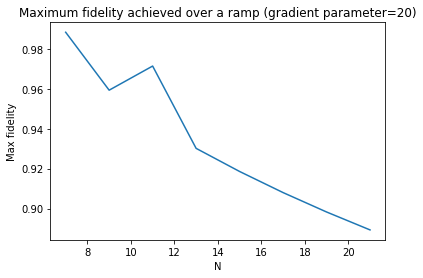

In [29]:
plt.plot(Ns, np.dot(-1,results))
plt.title("Maximum fidelity achieved over a ramp (gradient parameter=20)")
plt.xlabel("N")
plt.ylabel("Max fidelity")
plt.show()

In [240]:
Ntimes

[67.60385513305664,
 72.26031804084778,
 55.960514068603516,
 63.46703004837036,
 93.78250098228455,
 369.6783220767975,
 2382.756406068802,
 5912.075711011887]

In [67]:
bounds=[(0.1,20)]
params = initialiseSimulation(7, 'AFM', 'forward')
t_init=time.time()
result = scipy.optimize.shgo(maxFidelityCostFunction, bounds, (params,
                                                               0.01, 0.01), n=10, iters=1,
                                                               sampling_method='sobol')
elapsed=time.time()-t_init

print(result)
print('elapsed time = ', elapsed)


     fun: -0.9859695799851248
    funl: array([-0.98596958, -0.97644533, -0.9739195 , -0.97346546])
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 2
   nlfev: 57
   nlhev: 0
   nljev: 19
 success: True
       x: array([19.49378813])
      xl: array([[19.49378813],
       [ 4.43245978],
       [ 1.        ],
       [12.97922592]])
elapsed time =  2367.480658054352


In [272]:
for i in range(3,17,2):
    
    bounds=[(0.1,20)]
    magneticorder = 'AFM'
    params = initialiseSimulation(i, magneticorder, 'forward', k=i-1)
    t_init=time.time()
    result = scipy.optimize.shgo(maxFidelityCostFunction, bounds, (magneticorder, params,
                                                               0.01, 0.01), n=10, iters=1,
                                                               sampling_method='sobol')
    elapsed=time.time()-t_init

    print(result)
    print('elapsed time = ', elapsed)


     fun: -0.9999443840805262
    funl: array([-0.99994438])
 message: 'Optimization terminated successfully.'
    nfev: 23
     nit: 2
   nlfev: 3
   nlhev: 0
   nljev: 1
 success: True
       x: array([18.75625])
      xl: array([[18.75625]])
elapsed time =  67.01296210289001
     fun: -0.9914333485686885
    funl: array([-0.99143335])
 message: 'Optimization terminated successfully.'
    nfev: 53
     nit: 2
   nlfev: 33
   nlhev: 0
   nljev: 10
 success: True
       x: array([0.44908893])
      xl: array([[0.44908893]])
elapsed time =  164.37409901618958
     fun: -0.9786143088871578
    funl: array([-0.97861431])
 message: 'Optimization terminated successfully.'
    nfev: 91
     nit: 2
   nlfev: 71
   nlhev: 0
   nljev: 20
 success: True
       x: array([0.43228981])
      xl: array([[0.43228981]])
elapsed time =  280.8043098449707
     fun: -0.965080386837874
    funl: array([-0.96508039])
 message: 'Optimization terminated successfully.'
    nfev: 88
     nit: 2
   nlfev: 68
  

In [513]:
for i in range(3,17,2):
    
    bounds=[(0.1,5)]
    magneticorder = 'FM'
    params = initialiseSimulation(i, magneticorder, 'forward', k=i-1)
    t_init=time.time()
    result = scipy.optimize.shgo(maxFidelityCostFunction, bounds, ('FM', params,
                                                               0.01, 0.01), n=10, iters=1,
                                                               sampling_method='sobol')
    elapsed=time.time()-t_init

    print(result)
    print('elapsed time = ', elapsed)


     fun: -0.9640222884615522
    funl: array([-0.96402229, -0.9546083 , -0.93827953, -0.89047565])
 message: 'Optimization terminated successfully.'
    nfev: 539
     nit: 2
   nlfev: 519
   nlhev: 0
   nljev: 67
 success: True
       x: array([5.])
      xl: array([[5.        ],
       [3.50029328],
       [2.0221405 ],
       [0.55711278]])
elapsed time =  1182.2771308422089
     fun: -0.9184067703901564
    funl: array([-0.91840677, -0.78394829])
 message: 'Optimization terminated successfully.'
    nfev: 394
     nit: 2
   nlfev: 374
   nlhev: 0
   nljev: 44
 success: True
       x: array([5.])
      xl: array([[5.        ],
       [0.71162453]])
elapsed time =  1144.614343881607
     fun: -0.8847599236517542
    funl: array([-0.88475992, -0.80339326, -0.7611898 ])
 message: 'Optimization terminated successfully.'
    nfev: 59
     nit: 2
   nlfev: 39
   nlhev: 0
   nljev: 13
 success: True
       x: array([5.])
      xl: array([[5.        ],
       [2.63429702],
       [1.332302

In [528]:
for i in range(3,17,2):
    
    bounds=[(15,16)]
    magneticorder = 'FM'
    params = initialiseSimulation(i, magneticorder, 'backward', k=i-1)
    t_init=time.time()
    result = scipy.optimize.shgo(maxFidelityCostFunction, bounds, ('FM', params,
                                                               0.01, 0.01), n=10, iters=1,
                                                               sampling_method='sobol')
    elapsed=time.time()-t_init

    print(result)
    print('elapsed time = ', elapsed)


     fun: -0.9106409408054115
    funl: array([-0.91064094, -0.90822048])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 2
   nlfev: 22
   nlhev: 0
   nljev: 7
 success: True
       x: array([15.37433355])
      xl: array([[15.37433355],
       [16.        ]])
elapsed time =  1772.4620130062103
     fun: -0.7422529567972902
    funl: array([-0.74225296, -0.74180625])
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 2
   nlfev: 12
   nlhev: 0
   nljev: 4
 success: True
       x: array([15.84442253])
      xl: array([[15.84442253],
       [15.        ]])
elapsed time =  1187.9470601081848
     fun: -0.6246321824387103
    funl: array([-0.62463218, -0.62444973])
 message: 'Optimization terminated successfully.'
    nfev: 35
     nit: 2
   nlfev: 15
   nlhev: 0
   nljev: 5
 success: True
       x: array([15.])
      xl: array([[15.        ],
       [15.87413074]])
elapsed time =  1303.0273940563202
     fun: -0.610920448648867
    funl: arr

In [530]:
for i in range(3,17,2):
    
    bounds=[(15,16)]
    magneticorder = 'AFM'
    params = initialiseSimulation(i, magneticorder, 'backward', k=i-1)
    t_init=time.time()
    result = scipy.optimize.shgo(maxFidelityCostFunction, bounds, (magneticorder, params,
                                                               0.01, 0.01), n=10, iters=1,
                                                               sampling_method='sobol')
    elapsed=time.time()-t_init

    print(result)
    print('elapsed time = ', elapsed)


     fun: -0.8333377049718074
    funl: array([-0.8333377 , -0.8333375 , -0.83330757])
 message: 'Optimization terminated successfully.'
    nfev: 570
     nit: 2
   nlfev: 550
   nlhev: 0
   nljev: 75
 success: True
       x: array([15.74931718])
      xl: array([[15.74931718],
       [15.38588814],
       [15.01593043]])
elapsed time =  22311.49528694153


FileNotFoundError: [Errno 2] No such file or directory: 'Hinitial_5backwardAFM.npz'

In [544]:
for i in range(5,17,2):
    
    bounds=[(15,16)]
    magneticorder = 'AFM'
    params = initialiseSimulation(i, magneticorder, 'backward', k=i-1)
    t_init=time.time()
    result = scipy.optimize.shgo(maxFidelityCostFunction, bounds, (magneticorder, params,
                                                               0.01, 0.01), n=10, iters=1,
                                                               sampling_method='sobol')
    elapsed=time.time()-t_init

    print(result)
    print('elapsed time = ', elapsed)

     fun: -0.7572163440113736
    funl: array([-0.75721634, -0.75715534, -0.75706406])
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
   nlfev: 43
   nlhev: 0
   nljev: 14
 success: True
       x: array([15.92911318])
      xl: array([[15.92911318],
       [15.40158417],
       [15.        ]])
elapsed time =  2554.8488199710846
     fun: -0.7126190890205537
    funl: array([-0.71261909, -0.71246069])
 message: 'Optimization terminated successfully.'
    nfev: 59
     nit: 2
   nlfev: 39
   nlhev: 0
   nljev: 13
 success: True
       x: array([16.])
      xl: array([[16.        ],
       [15.60492008]])
elapsed time =  2376.5685470104218
     fun: -0.6823510111097746
    funl: array([-0.68235101, -0.68229902])
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
   nlfev: 41
   nlhev: 0
   nljev: 13
 success: True
       x: array([15.37944155])
      xl: array([[15.37944155],
       [16.        ]])
elapsed time =  2497.3009691238403
    

In [668]:
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy import Function
from sympy.abc import x
f = implemented_function('f', lambda x: np.random.normal(0,sqrt(x)))
lam_f = lambdify(x, f(x), modules=['numpy'])

def tanhRampNoisy(t, g, n):
    return (1+(n*lam_f(t)))*0.5*(tanh((t+(2*g*atanh((2*0.01)-1)/2))/g)+1)

def generateNoisyRamp(g, dt=0.005, p=0.01, n=0.03):
    tmax = -2*atanh(2*p-1)
    ramp = []
    t_curr = 0
    while t_curr < 5:
        ramp.append(float(tanhRampNoisy(t_curr,g, n)))
        t_curr += dt
    return ramp

def generateNoisyRamp2(g, dt=0.005, p=0.01, n=0.03):
    tmax = -2*atanh(2*p-1)
    ramp = []
    t_curr = 0
    while t_curr < 5:
        p = float(tanhRampNoisy(t_curr,g,n))
        if p > 0:
            if p < 1:
                ramp.append(p)
            else:
                ramp.append(1)
        else:
            ramp.append(0)
        t_curr += dt
    return ramp 

In [669]:
generateNoisyRamp(2)

[0.010000000000000009,
 0.010048086571348662,
 0.010081346787517905,
 0.010191376538570338,
 0.010127520737571791,
 0.010301391979840174,
 0.010360449557953936,
 0.010411237417584594,
 0.010374679625373211,
 0.010422004497160854,
 0.010491069704370023,
 0.010638234532048502,
 0.010704967429019515,
 0.010786804215640265,
 0.010749705645768349,
 0.010722537436433198,
 0.010813628899525541,
 0.010811045359837288,
 0.010901601003885462,
 0.0109419608715809,
 0.011168944973507136,
 0.011061764615424017,
 0.011276362669226568,
 0.011172534075603403,
 0.011325759503582784,
 0.011355117841398796,
 0.011586387784838715,
 0.01155475193616342,
 0.01136132768718524,
 0.011543680723952447,
 0.011508933117752708,
 0.011740853046783475,
 0.011710209517741973,
 0.01169829205715366,
 0.011762918026372924,
 0.01194112968082756,
 0.01210678892090226,
 0.012014042625023745,
 0.01207211458489502,
 0.01210238249342602,
 0.012547136635363559,
 0.012252894065752773,
 0.012192482806745843,
 0.01220513247792281

In [613]:
def maxFidelityNoisyChain(grad, magneticorder=None, simulationparameters=None,
                          ramp=None, dt=0.01, p=0.01):

    initialState, targetState, H, Htar, V, F = simulationparameters 
    
    # Calculating the simulation time
    T = -2*grad*atanh(2*p-1)
    
    # Setting up the simulation
    currentState = initialState
    f = []
    ramps = []
    t_curr = 0
    rampcounter = 0

    while (t_curr < 5 and rampcounter + 2 < len(ramp)): 
        # Updating the Hamiltonian
        
        Hcurr = (1-ramp[rampcounter])*H + ramp[rampcounter]*Htar
        H_dt2 = (1-ramp[rampcounter+1])*H + ramp[rampcounter+1]*Htar
        H_dt = (1-ramp[rampcounter+2])*H + ramp[rampcounter+2]*Htar
        
        rampcounter = rampcounter + 2

        # Performing the Runge-Kutta step
        currentState = rungeKuttaStep(currentState, Hcurr, H_dt2, H_dt, dt)
        
        # Renormalising the state
        currentState = normalizeSparse(currentState)
        if magneticorder == 'AFM':
            # Transforming the state into the space to calculate fidelity
            currentState_f = F.transpose()*V*currentState
        
            # Appending current fidelity to array
            f.append(abs(currentState_f).power(2).sum())
            
        elif magneticorder == 'FM':
            f.append(np.abs(np.dot(flatten(targetState.toarray()), flatten(currentState.toarray()))))
        
        ramps.append(ramp[rampcounter])
        t_curr += dt

    #plt.figure(figsize=(8,6), dpi=70)
    #plt.plot([i*dt for i in range(len(f))],f, color='blue')
    #plt.plot([i*dt for i in range(len(ramps))],ramps, '--', color='red')
    #plt.ylabel("Fidelity")
    #plt.xlabel("$Jt$")
    #plt.show()
    
    return np.max(f)

In [614]:
params = initialiseSimulation(15, 'AFM', 'forward')
grad = 0.421

noisyFs = []

for i in range(1000):
    ramp = generateNoisyRamp2(grad)
    noisyFs.append(maxFidelityNoisyChain(grad, magneticorder='AFM',
                                         simulationparameters=params, ramp=ramp, dt=0.01, p=0.01))
    print(noisyFs[i], i)

print(np.average(noisyFs))

0.928831245579839
0.9288254322013595
0.928836760515857
0.9288376266819844
0.9288481669447002
0.9288177006677225
0.9288419301721534
0.9288269285591373
0.9288270748736294
0.9288426951966003
0.9288373268641068
0.9288347518953812
0.9288177979580418
0.9288197834152874
0.9288290223172087
0.9288529233855648
0.9288444368407697
0.9288077637435311
0.9288374184189718
0.9288392499745384
0.9288493267183285
0.9288274779113175
0.928842402889891
0.9288178047287409
0.9288230256298123
0.9288048791407866
0.9288304115470276
0.9288215849899213
0.9288687862239728
0.9288162050569088
0.928834492754167
0.9288517611927298
0.928844222587979
0.9288224563641934
0.9288356235138876
0.9288737148729755
0.9288451965920013
0.9288258112201504
0.9288206516532826
0.9288448737621986
0.9288231335226278
0.9288146762626066
0.9288309512144122
0.9288377603084312
0.9288360080417353
0.9288480198006035
0.9288240583717204
0.9288141500822185
0.9288224488866479
0.9288477442457601
0.9288336525147994
0.9288527038547671
0.928848516834245

0.9288496254685366
0.9288334930906829
0.928836100991665
0.9288403748431682
0.9288167516874017
0.9288341437147286
0.9288254236354507
0.928830057946251
0.9288436339107462
0.9288358050002045
0.9288435615158522
0.9288372309383371
0.9288292063281053
0.9288266260352036
0.9288243140153107
0.9288061678578499
0.928828340074666
0.9288465522355118
0.9288320463625986
0.9288280701007854
0.928830298464725
0.9288214492196913
0.9288364901012336
0.9288215116604263
0.9288575261310283
0.9288237688721155
0.9288408897767835
0.928848996857911
0.9288241378389468
0.928840522130244
0.9288453981284742
0.9288360827539328
0.9288350827482517
0.9288504791449449
0.9288088327202992
0.9288546896051202
0.9288230492145042
0.928834737985214
0.9288650659519896
0.9288220031012662
0.9288170439174174
0.9288235262339397
0.9288442630209217
0.9288667177271475
0.928829127642468
0.9288136973154613
0.9288503292958039
0.9288134497161635
0.928854137861151
0.9288192636046049
0.9288513129113434
0.9288107567896166
0.9288383103802724
0.

0.9288223555860331
0.9288456696819175
0.9288245875078517
0.92882981181385
0.9288437114181733
0.9288056713700947
0.9288348632413386
0.9288330596914406
0.9288282025750588
0.9288144354497202
0.9288125291075112
0.9288563840018886
0.9288497945355446
0.9288237519091601
0.9288189867366048
0.9288613802651232
0.928818869565558
0.9288300113834129
0.9288321430387384
0.928840419159556
0.9288261767455157
0.9288270144240456
0.9288478644531057
0.9288442082791122
0.9288347650449658
0.9288228356344244
0.9288354293895008
0.9288214772738126
0.9288247760255485
0.9288343846076919
0.9288279000280171
0.9288429497762759
0.9288569388178612
0.9288271044082808
0.9288282303066164
0.9288389879329217
0.9288269763732819
0.9288076404436382
0.9288201937447513
0.9288313440783298
0.9288301687200593
0.9288561109810622
0.928824645901552
0.9288432228337549
0.9288518884013388
0.9288540676483525
0.9288273228481618
0.9288405430844345
0.9288500230810166
0.9288401456526989
0.9288461628453208
0.9288297664343882
0.928837201446597

In [618]:
print(np.mean(noisyFs),
np.std(noisyFs),
np.min(noisyFs))

0.9288334431026717 1.3671778569478773e-05 0.9287846400677355


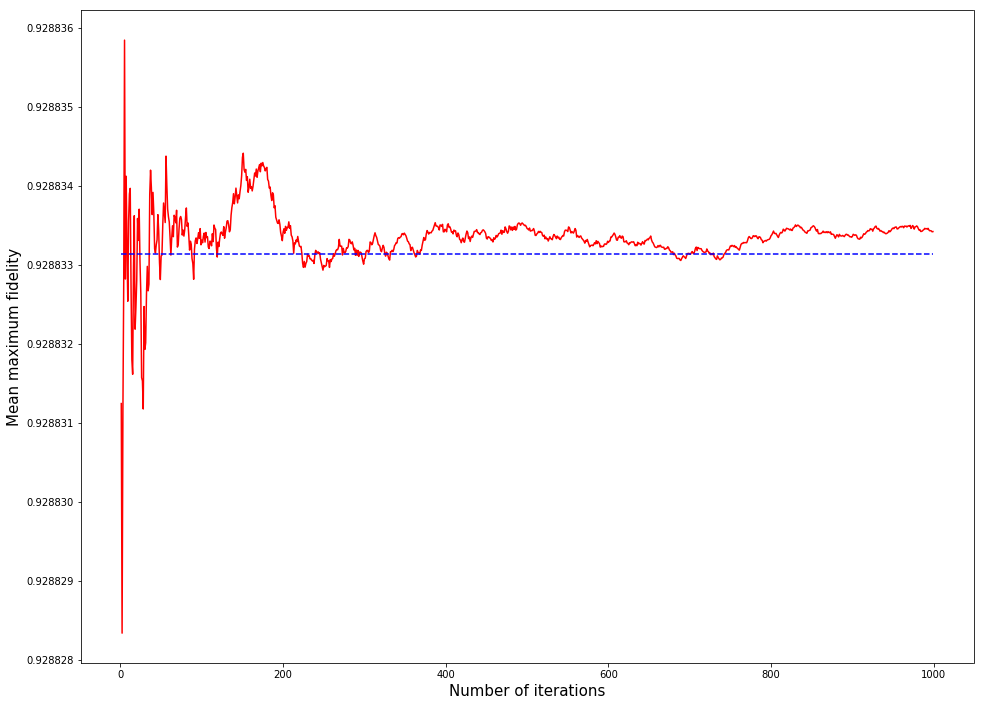

In [644]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot([i for i in range(1,len(noisyFs))],[np.mean(noisyFs[:i]) for i in range(1,len(noisyFs))], color='red')
ax.plot([i for i in range(1,len(noisyFs))], [0.9288331426696093 for i in range(1, len(noisyFs))],'--', color='blue')
ax.ticklabel_format(useOffset=False)
ax.set_ylabel("Mean maximum fidelity", fontsize=15)
ax.set_xlabel("Number of iterations", fontsize=15)
plt.show()

In [645]:
hist, bin_edges = np.histogram(noisyFs)

In [656]:
hist

array([  2,  14,  41, 168, 272, 227, 183,  76,  15,   2])

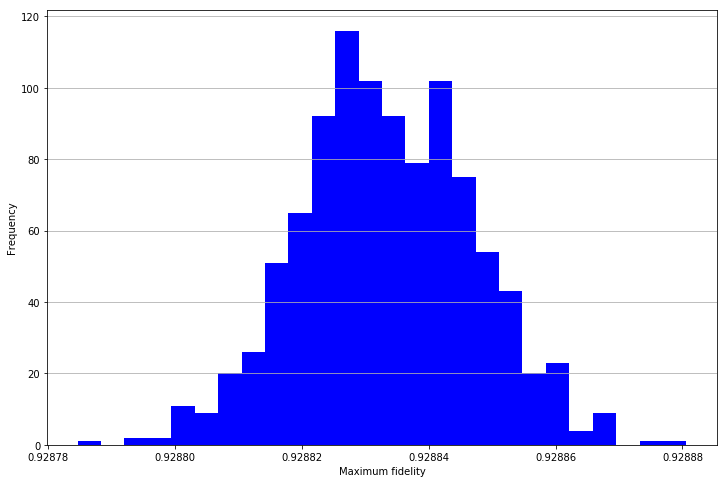

In [666]:
plt.figure(figsize=(12,8))
plt.hist(x=noisyFs, bins='auto', color='blue')
plt.grid(axis='y')
plt.xlabel('Maximum fidelity')
plt.ylabel('Frequency')
plt.show()
# Set a clean upper y-axis limit.


In [ ]:
params = initialiseSimulation(15, 'AFM', 'forward')
grad = 0.421

Xis = []
minFs = []

for i in range(4,18):
    noisyFs = []
    for j in range(300):

        ramp = generateNoisyRamp2(grad, n=0.01*i)
        noisyFs.append(maxFidelityNoisyChain(grad, magneticorder='AFM',
                                         simulationparameters=params, ramp=ramp, dt=0.01, p=0.01))
    minFs.append(np.min(noisyFs))
    Xis.append(0.01*i)

In [ ]:
def generateThermalStates(N, kopt=6):
    H = makeHamiltonianJ(N,[1 for i in range(N-1)])
    eigval, eigvec = scipy.sparse.linalg.eigsh(H, k=kopt, which='SA')
    return [eigvec[:,i] for i in range(len(eigval))] , eigval

In [ ]:
def initialiseSimulationThermal(N, magneticorder, rampdir, AFMState):

    AFMState = phaseCorrectAFM(N-1, AFMState)
    targetState = 0
    initialState_fs = scipy.sparse.kron([0,1], AFMState).transpose()

    # Loading the sparse matrix V\dagger and
    V = scipy.sparse.load_npz('V_'+str(N)+'_allJ_Sz_1subspace.npz')
    F = scipy.sparse.load_npz('F_'+str(N)+'_allJ_Sz_1subspace.npz')

    # Transforming initial state into contracted space
    initialState = V.transpose()*initialState_fs

    H = scipy.sparse.load_npz('Hinitial_'+str(N)+rampdir+magneticorder+'.npz')
    Htar = scipy.sparse.load_npz('Htarget_'+str(N)+rampdir+magneticorder+'.npz')

    return initialState, targetState, H, Htar, V, F
    

In [ ]:
states, energies = generateThermalStates(14, kopt=5)
Fs = []

grad = 0.421

for state in states:
    params = initialiseSimulationThermal(15, 'AFM', 'forward', state)
    Fs.append(-1*maxFidelityCostFunction(grad, magneticorder='AFM', simulationparameters=params,
                                             dt=0.01, p=0.01))
              
plt.plot(energies, Fs)
plt.show()